In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

In [3]:
import pandas as pd

In [4]:
datapath="../../datasets/OpenSecrets/Yang_Ruan_Data_20240304/"
datapath_og="../../datasets/OpenSecrets/Yang_Ruan_Data_20240304_original/"

In [45]:
valid = pd.read_excel(f"{datapath_og}industries_catcode.xlsx")

In [47]:
valid.head()

,Catcode,Catname,Catorder,Industry,Sector,Sector Long
0,A0000,Agriculture,A11,Misc Agriculture,Agribusiness,Agribusiness
1,A1000,Crop production & basic processing,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
2,A1100,Cotton,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
3,A1200,Sugar cane & sugar beets,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
4,A1300,Tobacco & Tobacco products,A02,Tobacco,Agribusiness,Agribusiness


In [11]:
table_names = ["agency", "bills", "indus", "issue", "issue_nospecificissue", "lobbying", "lobbyist"]

In [37]:
t = "lobbyist"

In [38]:
valid = pd.read_csv(f"{datapath}lob_{t}.csv", encoding="utf8")

In [41]:
valid.set_index(["year", "uniqid"], inplace=True)

In [42]:
len(valid)

1246042

In [40]:
valid.head()

,uniqid,lobbyist_raw,lobbyistnew,lobbyist_id,year,officialposition,cid,formercongmem
0,000018d7-73cf-403c-bafb-e423afd81c67,"SHAW, REBECCA LOUISE","Shaw, Rebecca",Y0000059741L,2022,"(Rep. Devin Nunes), Paid Intern, (Rep. Chris G...",NaN,n
1,000018d7-73cf-403c-bafb-e423afd81c67,"HARLOW, BRYCE","Harlow, Bryce L",Y0000040476L,2022,NaN,NaN,n
2,000018d7-73cf-403c-bafb-e423afd81c67,"CASTALDO, KEITH","Castaldo, Keith",Y0000058249L,2022,NaN,NaN,n
3,000018d7-73cf-403c-bafb-e423afd81c67,"STANTON, SHANTI","Stanton, Shanti Ochs",Y0000001722L,2022,NaN,NaN,n
4,00003552-CB8B-432D-A5E4-0F7D22AFCE59,"THOMPSON, MARGARET","Thompson, Meg",Y0000036079L,2020,"Professional Staff Member, House Appropriation...",NaN,n


In [33]:
valid["isfirm"].value_counts()

isfirm
y    481188
Name: count, dtype: int64

In [16]:
valid.loc[8061]

client     Alaka’i Defense Systems
sub        Alaka’i Defense Systems
total                      20000.0
year                          2023
type                            q3
catcode                      D4000
Name: 8061, dtype: object

In [2]:
from google.cloud import bigquery

client = bigquery.Client()

In [48]:
job = client.load_table_from_dataframe(
    #valid.set_index("catcode"), f"main-street-labs.company_datasets_dev.open_secrets_lob_indus")
    # valid.set_index("si_id"), f"main-street-labs.company_datasets_dev.open_secrets_lob_{t}")
    # valid, f"main-street-labs.company_datasets_dev.open_secrets_lob_{t}")
    valid.set_index("Catcode"), f"main-street-labs.company_datasets_dev.open_secrets_industries_catcode")

In [ ]:
for t in ["lobbying", "lobbyist"]:
    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True,
    )
    with open(f"{datapath}lob_{t}.csv", "rb") as source_file:
        job = client.load_table_from_file(source_file, f"main-street-labs.company_datasets_dev.open_secrets_lob_{t}", job_config=job_config)
    job.result()

# analysis

In [5]:
valid.head()

,client,sub,total,year,type,catcode
0,(ISC)2,(ISC)2,15000.0,2018,q4,Y4000
1,(ISC)2,(ISC)2,40000.0,2021,q4,Y4000
2,(ISC)2,(ISC)2,30000.0,2021,q3,Y4000
3,"1,000 Days","1,000 Days",20000.0,2018,q2,Y4000
4,"1,000 Days","1,000 Days",30000.0,2018,q1,Y4000


In [6]:
valid_yr = valid.groupby("year")

In [11]:
valid2023 = valid_yr.get_group(2023)

In [13]:
len(valid2023)

51564

In [17]:
valid2023.columns

Index(['client', 'sub', 'total', 'year', 'type', 'catcode'], dtype='object')

In [26]:
valid2023["catcode"].value_counts()

catcode
Y4000    6907
X3000    4797
H5100    2035
H2100    1483
X4000     943
         ... 
f3000       2
G5600       1
T8000       1
j9000       1
f1400       1
Name: count, Length: 443, dtype: int64

In [58]:
valid2023_cat = valid2023.set_index("catcode")

In [ ]:
# X4000 is defense?

In [67]:
def sum_quarters(g):
    total = g["total"].sum()
    count = len(g)
    return pd.Series({"total": total, "num_quarters": count})

In [68]:
valid2023_annualtotal = valid2023.groupby(["client", "sub", "year", "catcode"]).apply(sum_quarters)

In [69]:
valid2023_annualtotal.head()

,,,,total,num_quarters
client,sub,year,catcode,,
10 Tanker Air Carrier LLC,10 Tanker Air Carrier LLC,2023,T1000,80000.0,4.0
10x Genomics,10x Genomics,2023,H4500,280000.0,4.0
11:11 Media,11:11 Media Impact,2023,C2000,120000.0,4.0
1722 Eye Street Associated LP,1722 Eye Street Associated LP,2023,H1120,28000.0,1.0
1776 Healthcare,1776 Healthcare,2023,H0000,12500.0,4.0


In [84]:
len(valid2023_annualtotal.reset_index()["client"].unique())

13687

In [82]:
len(valid2023_annualtotal)

14602

In [81]:
valid2023_annualtotal["total"].mean()

291649.6615532119

In [72]:
valid2023_annualtotal.reset_index().to_csv("lob_indus_2023_annualtotal.csv", index=False)

<Axes: >

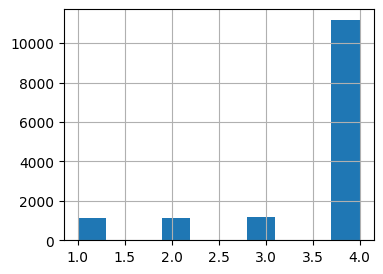

In [77]:
valid2023_annualtotal["num_quarters"].hist(figsize=(4, 3))

<Axes: >

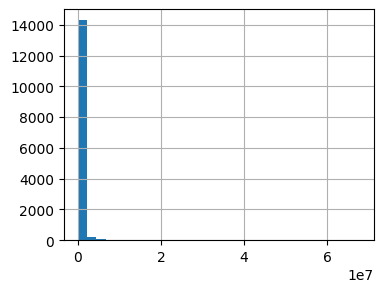

In [78]:
valid2023_annualtotal["total"].hist(bins=30, figsize=(4,3))

# convert raw to valid csv

In [44]:
def convert_to_valid_csv(table_name, codec="windows-1252"):
    raw = pd.read_csv(f"{datapath_og}Yang_Ruan_{table_name}.txt", quotechar="'", encoding=codec)
    print(len(raw))
    print(raw.columns)
    raw.to_csv(f"{datapath}{table_name}.csv", encoding='utf8', index=False)
    return raw

In [39]:
raw = convert_to_valid_csv("lob_agency")

1516158
Index(['uniqid', 'agencyid', 'agency'], dtype='object')


In [40]:
raw = convert_to_valid_csv("lob_bills")

/tmp/ipykernel_10466/1381348056.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(f"{datapath_og}Yang_Ruan_{table_name}.txt", quotechar="'", encoding="windows-1252")


2284902
Index(['b_id', 'si_id', 'congno', 'billid'], dtype='object')


In [37]:
raw = convert_to_valid_csv("lob_issue")

1108014
Index(['si_id', 'uniqid', 'issueid', 'issue', 'specificissue', 'year', 'type'], dtype='object')


In [42]:
raw = convert_to_valid_csv("lob_issue_nospecificissue")

1108014
Index(['si_id', 'uniqid', 'issueid', 'issue', 'year', 'type'], dtype='object')


### lob_lobbying preview

In [33]:
raw = convert_to_valid_csv("lob_lobbying")

564122
Index(['uniqid', 'registrant_raw', 'registrant', 'isfirm', 'client_raw',
       'client', 'ultorg', 'amount', 'catcode', 'source', 'self',
       'includensfs', 'use', 'ind', 'year', 'type', 'typelong'],
      dtype='object')


In [34]:
raw["catcode"].value_counts()

catcode
Y4000    43651
X3000    37005
H5100    17389
H2100    14473
H4300    12746
         ...  
e1300        3
t1600        3
e4100        2
J5400        2
f5300        1
Name: count, Length: 475, dtype: int64

In [36]:
raw.set_index("catcode").loc["Y4000"].head()

,uniqid,registrant_raw,registrant,isfirm,client_raw,client,ultorg,amount,source,self,includensfs,use,ind,year,type,typelong
catcode,,,,,,,,,,,,,,,,
Y4000,0003eca1-4e3a-43cb-a3c5-7426cd761a58,PAUL SUPLIZIO ASSOCIATES,Paul Suplizio Assoc,y,REPEAL BEAT COALITION (BASE EROSION ANTI-ABUSE...,Repeal BEAT Coalition,Repeal BEAT Coalition,5000.0,,n,NaN,y,y,2022,q1,FIRST QUARTER REPORT
Y4000,000B3805-A816-4DB1-B00C-16023F9E0791,Pillsbury Winthrop Shaw Pittman LLP,"Pillsbury, Winthrop et al",y,"The Rader Group, PLLC on behalf of Nuctech",Nuctech Co,Nuctech Co,10000.0,,n,NaN,y,y,2018,q3,THIRD QUARTER REPORT
Y4000,000f847e-ee5d-4618-913a-69db0009e4d1,RIDGE POLICY GROUP,Ridge Policy Group,y,SCRATCHWORKS,Scratchworks,Scratchworks,10000.0,,n,NaN,y,y,2021,q1,FIRST QUARTER REPORT
Y4000,000F9037-62D6-4FE3-8C8C-C51A29BAB593,AMBASSADOR HUGO LLORENS AND GLOBAL PARTNERS LLC,Ambassador Hugo Llorens & Global Partners LLC,y,Alejandro Chahin,"Chahin, Alejandro","Chahin, Alejandro",0.0,,n,NaN,y,y,2020,q1,FIRST QUARTER REPORT
Y4000,00105698-503C-4B43-A125-8750417B94C8,Rulon & White Governance Strategies,Rulon & White Governance Strategies,y,INTERNATIONAL OUTDOOR,International Outdoor,International Outdoor,0.0,,n,NaN,y,y,2019,q2,SECOND QUARTER REPORT


### lob_lobbyist preview

In [47]:
raw = convert_to_valid_csv("lob_lobbyist", "cp850")

1246042
Index(['uniqid', 'lobbyist_raw', 'lobbyistnew', 'lobbyist_id', 'year',
       'officialposition', 'cid', 'formercongmem'],
      dtype='object')


In [48]:
raw.head()

,uniqid,lobbyist_raw,lobbyistnew,lobbyist_id,year,officialposition,cid,formercongmem
0,000018d7-73cf-403c-bafb-e423afd81c67,"SHAW, REBECCA LOUISE","Shaw, Rebecca",Y0000059741L,2022,"(Rep. Devin Nunes), Paid Intern, (Rep. Chris G...",NaN,n
1,000018d7-73cf-403c-bafb-e423afd81c67,"HARLOW, BRYCE","Harlow, Bryce L",Y0000040476L,2022,NaN,NaN,n
2,000018d7-73cf-403c-bafb-e423afd81c67,"CASTALDO, KEITH","Castaldo, Keith",Y0000058249L,2022,NaN,NaN,n
3,000018d7-73cf-403c-bafb-e423afd81c67,"STANTON, SHANTI","Stanton, Shanti Ochs",Y0000001722L,2022,NaN,NaN,n
4,00003552-CB8B-432D-A5E4-0F7D22AFCE59,"THOMPSON, MARGARET","Thompson, Meg",Y0000036079L,2020,"Professional Staff Member, House Appropriation...",NaN,n


In [54]:
lob_lobbyist = raw.set_index(["lobbyist_id", "year"])

In [56]:
len(lob_lobbyist.index)

1246042

In [57]:
len(lob_lobbyist.index.unique())

84903